In [42]:
import pycuda
import pycuda.autoinit
from pycuda.tools import make_default_context

c = make_default_context()
d = c.get_device()
print('pycuda:', d.name())

import torch

print('torch gpu:', torch.cuda.is_available(), ', ', torch.cuda.get_device_name(0))

pycuda: Tesla T4
torch gpu: True ,  Tesla T4


In [43]:
import time
import matplotlib.pyplot as plt

def g2_correlation_Lucas(intensity_image, q_vector):
    # Convert q_vector to torch tensor if it's not already one
    q_vector = torch.tensor(q_vector)

    Im_disp = torch.roll(intensity_image, shifts=tuple(q_vector), dims=(0,1))

    numerator = torch.mean(intensity_image * Im_disp)
    denominator = torch.mean(intensity_image) ** 2

    # Compute the normalized second-order correlation
    g2 = numerator / denominator

    return g2

In [44]:
image = torch.ones([1000, 1000], device='cuda')
N_corr_c2 = 100  # number of pixels to use for the auto-correlation
c2j = torch.zeros([N_corr_c2, N_corr_c2], device='cuda')

start_time = time.time()

for q1, q11 in enumerate(range(-int(N_corr_c2 / 2) - 1, int(N_corr_c2 / 2) - 1, 1)):
    for q2, q22 in enumerate(range(-int(N_corr_c2 / 2) - 1, int(N_corr_c2 / 2) - 1, 1)):
        c2j[q2, q1] = g2_correlation_Lucas(image, [q11, q22])  # compute g2 for each q1, q2
        
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 3.96520733833313 seconds


In [45]:
import concurrent.futures

image = torch.ones([1000, 1000], device='cuda')
N_corr_c2 = 100  # number of pixels to use for the auto-correlation
c2j = torch.zeros([N_corr_c2, N_corr_c2], device='cuda')

def compute_g2(q1, q2, image):
    return g2_correlation_Lucas(image, [q1, q2])

q_range = range(-int(N_corr_c2 / 2) - 1, int(N_corr_c2 / 2) - 1, 1)
q_pairs = [(q1, q2) for q1 in q_range for q2 in q_range]

start_time = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda q: compute_g2(q[0], q[1], image), q_pairs))

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

for idx, (q1, q2) in enumerate(q_pairs):
    c2j[q2 + int(N_corr_c2 / 2) + 1, q1 + int(N_corr_c2 / 2) + 1] = results[idx]     

Execution time: 2.451313018798828 seconds


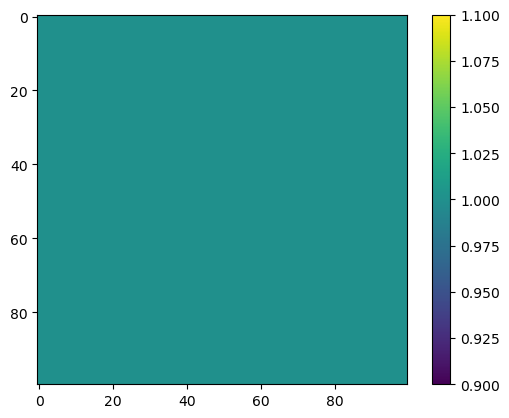

In [46]:
plt.imshow(c2j.cpu().numpy())
plt.colorbar()